In [31]:
# "Проверка гипотезы: Разворот зависит от предыдущих курсов (вернее, разниц с текущей) и, возможно, volumes. 
# Задача  разбивается на следующие: 1) определение разворота 2) тестированию гипотезы 
# Пока я в процессе решеения первой задачи.    

In [32]:
from get_data import get_polo_data
import math
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn import metrics 
from sklearn import svm
from pandas import DataFrame
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import plotly.graph_objects as go
import numpy as np
from scipy.signal import argrelextrema

In [33]:
# РАБОТАЮ с пятиминутками! 
sd = get_polo_data(pair="USDT_BTC", frame=(4)*60*60*24,zoom='5MIN')
print("Download from polo",len(sd))
print("Errors values",len(sd)-len(sd.dropna()))

DEBUG:poloniex:Getting 2019-12-20 13:55:00 - 2019-12-20 14:08:47 USDT_BTC candles from Poloniex...
DEBUG:poloniex:Updating USDT_BTC database with 3 entrys...
100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 375.00it/s]
DEBUG:poloniex:Getting USDT_BTC chart data from db


Download from polo 1152
Errors values 0


In [34]:
def SetDataFrameMinMax(n_sosed, n_lags):   
    
    #В цикле инициализируются столбцы - исходные  параметры для маш обучения   
    for i in range(0, n_lags): #создаем столбцы, курc: разница между текущим и i (макс количество передается в функции)
        sd["Lag%s" % str(i+1)] = sd["open"]-sd["open"].shift(i+1)
        sd["Vol%s" % str(i+1)] = sd["volume"].shift(i+1)
    
    # здесь нахожу минимумы и максимумы. Еще потестю на твоей функции 
    sd['min'] = sd.iloc[argrelextrema(sd.open.values, np.less_equal, order=n_sosed)[0]]['open']
    sd['max'] = sd.iloc[argrelextrema(sd.open.values, np.greater_equal, order=n_sosed)[0]]['open']
    
    #дальше инициируем два столбца. extr - значение экстремума (для визульного контроля на графике) и is_extr=1 если экстремум
    #под экстремумом понимает разворот 
    for z, row in sd.iterrows():      
        sd.loc[z,'is_extr']=0
        if (np.isnan(sd.loc[z,'min'])==False):
            sd.loc[z,'extr']=sd.loc[z,'min']
            sd.loc[z,'is_extr']=1
        if (np.isnan(sd.loc[z,'max'])==False):
            sd.loc[z,'extr']=sd.loc[z,'max']
            sd.loc[z,'is_extr']=1
        
          
def ShowMyFig2(): 
    #графика для контроля. Сейчас min и max не видно, так как совпадают с extr 
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=sd.index, y=sd['open'],mode='lines',name="open_val"))
    fig.add_trace(go.Scatter(x=sd.index, y= sd['min'],mode='markers',name="min"))
    fig.add_trace(go.Scatter(x=sd.index, y= sd['max'],mode='markers',name="max"))
    fig.add_trace(go.Scatter(x=sd.index, y= sd['extr'],mode='markers',name="extr"))
    fig.show()


In [35]:
# lags, prec =10, 0.9
# SetDataFrameFromLagPrec(lags,prec)
# ShowMyFig()
# график своеобразный и кривой, но вроде показательный. Наверняка можно сделать лучше. Но как?

n_sosed=20
n_lags=5  #сколько столбцов с Lag-ми создавать 

SetDataFrameMinMax(n_sosed,n_lags)
print ("Найдено {} экстремумов из {} значений".format(sd['is_extr'].sum(),len(sd)))
ShowMyFig2() 

Найдено 40.0 экстремумов из 1152 значений


In [36]:
sd=sd.fillna(0)   #обнуляю nan чтобы работали функции маш обучения 
train=sd[['Vol1','Vol2','Vol3','Lag1','Lag2','Lag3']]
# train=sd[['open']]
target=sd['is_extr']
train_parm, test_parm, train_indic, test_indic = model_selection.train_test_split(
    train, target, test_size = 0.3, random_state = 0)


In [37]:
model_rfc = RandomForestClassifier(n_estimators = 70) #в параметре передаем кол-во деревьев
model_knc = KNeighborsClassifier(n_neighbors = 18) #в параметре передаем кол-во соседей
model_lr = LogisticRegression(penalty='l1', tol=0.01) 
model_svc = svm.SVC()

In [38]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

kfold=5
itog_val = {}
scores = cross_val_score(model_rfc, train, target, cv = kfold)
itog_val['RandomForestClassifier'] = scores.mean()
scores = cross_val_score(model_knc, train, target, cv = kfold)
itog_val['KNeighborsClassifier'] = scores.mean()
scores = cross_val_score(model_lr, train, target, cv = kfold)
itog_val['LogisticRegression'] = scores.mean()
scores = cross_val_score(model_svc, train, target, cv = kfold)
itog_val['SVC'] = scores.mean()

0.9652776209297949
0.9652776209297949
0.9652776209297949
0.9652776209297949


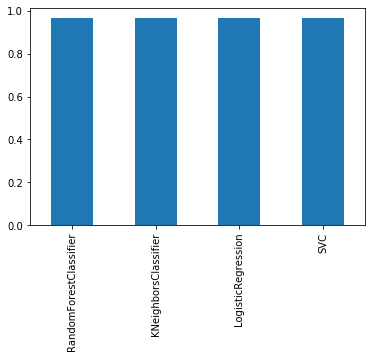

In [39]:
# Что-то слишком хорошо. Возможно, из за того что экстремумов намного больше чем неэкстремумов.  

for i in itog_val: 
    print (itog_val[i])
DataFrame.from_dict(data = itog_val, orient='index').plot(kind='bar', legend=False)

In [40]:
# ЭТО УЖЕ ОТЛАДКА. НЕ СМОТРИМ


n_sosed=5

from scipy.signal import argrelextrema

sd['min'] = sd.iloc[argrelextrema(sd.open.values, np.less_equal, order=n_sosed)[0]]['open']
sd['max'] = sd.iloc[argrelextrema(sd.open.values, np.greater_equal, order=n_sosed)[0]]['open']
    
# print (sd['min'])


# s = pd.Series([1,2,1,-4,-7,-2,-5,4,3,1,2,-1,-2,-3])

# extremums = s.groupby((np.sign(s).diff().fillna(0).ne(0)).cumsum()) \
#              .apply(lambda x: x.abs().max() * np.sign(x[x.abs().idxmax()]))


s = sd['open']

extremus2 = s.groupby((np.sign(s).diff().fillna(0).ne(0)).cumsum()) \
             .apply(lambda x: x.abs().max() * np.sign(x[x.abs().idxmax()]))

print(extremus2)

sd['min2'] = sd['open'].groupby((np.sign(sd['open']).diff().fillna(0).ne(0)).cumsum()) \
             .apply(lambda x: x.abs().max() * np.sign(x[x.abs().idxmax()]))

print(sd['min2'])

open
0    7416.41478
Name: open, dtype: float64
date
2019-12-16 14:10:00   NaN
2019-12-16 14:15:00   NaN
2019-12-16 14:20:00   NaN
2019-12-16 14:25:00   NaN
2019-12-16 14:30:00   NaN
                       ..
2019-12-20 13:45:00   NaN
2019-12-20 13:50:00   NaN
2019-12-20 13:55:00   NaN
2019-12-20 14:00:00   NaN
2019-12-20 14:05:00   NaN
Name: min2, Length: 1152, dtype: float64
